In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

import matplotlib
from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom

### Generate

In [4]:
ratio_table = np.empty((3, 4, 32), dtype=object) # 3 cases, 4 sessions, 32 channels

case_title = 'Fix'
case = 'all'
fs = 1200
tmax = 1.5
watch = '1 fixation'
tmin = 0 # include fix or not?

highpass = None
lowpass = None

sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)

interval = [0, 1.5]
t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
sessions = [sb, sa, rb, ra]

for channel in range(32):
        for i, session in enumerate(sessions):
            ratios = np.empty(())
            data = session[channel]
            psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False)
            bp_theta = fe.band_power(psds, freqs, [4, 8])
            bp_gamma = fe.band_power(psds, freqs, [30, 50])
            ratio = bp_theta/bp_gamma
            ratios = np.append(ratios, ratio)
            # tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
            ratio_table[0, i, channel] = ratios

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\eeg_analysis\funcs4eeg.py:181: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  evoked = epochs.get_data()
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\eeg_analysis\funcs4eeg.py:181: FutureWarning:

In [5]:
def align_slow(eeg, case, fs):
    if 'endo' in case:
        jump_from, jump_to = int((1.5+1+0.5)*fs), int((1.5+1+1)*fs)
    elif 'exo' in case:
        jump_from, jump_to = int((1.5+0.033*4+0.5)*fs), int((1.5+0.033*4+1)*fs)
    
    for channel in range(len(eeg)):
        eeg[channel] = np.concatenate((eeg[channel][:,:jump_from], eeg[channel][:,jump_to:]), axis=1)
        
    return eeg

case_title = 'endo'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)
    
    if 'slow' in case:
        # sham_before_slow = align_slow(sb, case, fs)
        # sham_after_slow = align_slow(sa, case, fs)
        # real_before_slow = align_slow(rb, case, fs)
        # real_after_slow = align_slow(ra, case, fs)

        sham_before_slow = sb
        sham_after_slow = sa
        real_before_slow = rb
        real_after_slow = ra

    else:
        sham_before_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

# exclude fixation
endo_fast_interval = [1.5+1, 1.5+1+0.5]
# endo_slow_interval = [1.5+1, 1.5+1+0.5+0.05+0.2]
endo_slow_interval = [1.5+1, 1.5+1+1]
exo_fast_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
# exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+1]

if 'endo' in case_title:
    intervals = [endo_fast_interval, endo_slow_interval]
else:
    intervals = [exo_fast_interval, exo_slow_interval]

slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow]
fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

for channel in range(32):
    for i in range(4):
            fast_session = fast_sessions[i][channel]
            slow_session = slow_sessions[i][channel]
            ratios = np.empty(())
            for j, data in enumerate([fast_session, slow_session]):
                interval = intervals[j]
                t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
                psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False)
                bp_theta = fe.band_power(psds, freqs, [4, 8])
                bp_gamma = fe.band_power(psds, freqs, [30, 50])
                ratio = bp_theta/bp_gamma
                ratios = np.append(ratios, ratio)
            # tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
            ratio_table[1, i, channel] = ratios

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\eeg_analysis\funcs4eeg.py:181: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  evoked = epochs.get_data()
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\eeg_analysis\funcs4eeg.py:181: FutureWarning:

In [6]:
case_title = 'exo'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)
    
    if 'slow' in case:
        # sham_before_slow = align_slow(sb, case, fs)
        # sham_after_slow = align_slow(sa, case, fs)
        # real_before_slow = align_slow(rb, case, fs)
        # real_after_slow = align_slow(ra, case, fs)

        sham_before_slow = sb
        sham_after_slow = sa
        real_before_slow = rb
        real_after_slow = ra

    else:
        sham_before_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

# exclude fixation
endo_fast_interval = [1.5+1, 1.5+1+0.5]
# endo_slow_interval = [1.5+1, 1.5+1+0.5+0.05+0.2]
endo_slow_interval = [1.5+1, 1.5+1+1]
exo_fast_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
# exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+1]

if 'endo' in case_title:
    intervals = [endo_fast_interval, endo_slow_interval]
else:
    intervals = [exo_fast_interval, exo_slow_interval]

slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow]
fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

for channel in range(32):
    for i in range(4):
            fast_session = fast_sessions[i][channel]
            slow_session = slow_sessions[i][channel]
            ratios = np.empty(())
            for j, data in enumerate([fast_session, slow_session]):
                interval = intervals[j]
                t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
                psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False)
                bp_theta = fe.band_power(psds, freqs, [4, 8])
                bp_gamma = fe.band_power(psds, freqs, [30, 50])
                ratio = bp_theta/bp_gamma
                ratios = np.append(ratios, ratio)
            # tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
            ratio_table[2, i, channel] = ratios

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\eeg_analysis\funcs4eeg.py:181: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  evoked = epochs.get_data()
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\eeg_analysis\funcs4eeg.py:181: FutureWarning:

### Analysis

In [7]:
def plot_colored_table(data, row_labels, col_labels, colors):
    # Format the data to 3 decimal places and add superscripts
    formatted_data = []
    for row in data:
        formatted_row = []
        for x in row:
            if x < 0.01:
                formatted_row.append(f"{x:.3f}**")
            elif x < 0.05:
                formatted_row.append(f"{x:.3f}*")
            else:
                formatted_row.append(f"{x:.3f}")
        formatted_data.append(formatted_row)

    # Adjust cell width
    cell_width = 0.15  # Increase cell width as needed

    # Create a figure with adjusted size
    fig, ax = plt.subplots(figsize=(6, 4))  # Adjust the figsize as needed

    # Hide the axes
    ax.axis('tight')
    ax.axis('off')

    # Create the table
    table = ax.table(
        cellText=formatted_data,
        rowLabels=row_labels,
        colLabels=col_labels,
        cellLoc='center',
        loc='center',
        colWidths=[cell_width] * len(col_labels)  # Set the width of each column
    )

    # Adjust table position
    table.scale(1, 1.5)  # Scale the table size (width, height)

    # # Color the text of row labels
    # for i, row_label in enumerate(row_labels):
    #     table[(i+1, 0)].get_text().set_color(colors[i % len(colors)])
    #     table[(i+1, 0)].set_text_props(weight='bold')

    plt.show()


channels = [24, 25, 26, 28]
sham_before = ratio_table[:, 0, channels]
sham_after = ratio_table[:, 1, channels]
real_before = ratio_table[:, 2, channels]
real_after = ratio_table[:, 3, channels]

# Set up the figure and axes
case_names = ['Fix', 'Endo', 'Exo']
colors = ['lightblue', 'blue', 'lightcoral', 'red']
# low_k = [1, 0.18, 100, 100]
# up_k = [3, 100, 3, 0.75] # 5.5

up_k =  np.array([[  3,   3, 2.5],  # sham before: fix endo exo
                  [ 10,  10,  10],  # sham after: fix endo exo
                  [  3,   3, 1.8],  # real before: fix endo exo
                  [  1, 0.5, 0.8]]) # real after: fix endo exo

low_k = np.array([[  3,   3,   3],  # sham before: fix endo exo
                  [  3, 0.2,   3],  # sham after: fix endo exo
                  [  3,   3,   3],  # real before: fix endo exo
                  [ 10,  10,  10]]) # real after: fix endo exo

means = np.ndarray((4, 3))
ses = np.ndarray((4, 3))
data_utest = np.ndarray((4, 3), dtype=object)
for i, data in enumerate([sham_before, sham_after, real_before, real_after]):
    for case in range(3):
        # print(i, case)
        one_case = np.stack(data[case,:])
        one_case_mean = np.mean(one_case, axis=0)
        # one_case_mean = np.where(one_case_mean<=1, np.nan, one_case_mean)
        # one_case_mean = one_case_mean[~np.isnan(one_case_mean)]
        one_case_mean = fe.rm_outlier(one_case_mean, lower_k=low_k[i, case], upper_k=up_k[i, case], verbose=False)
        num = len(one_case_mean)
        means[i, case] = np.nanmean(one_case_mean)
        one_case_std = np.nanstd(one_case_mean, axis=0)
        one_case_se = one_case_std/np.sqrt(num)
        ses[i, case] = one_case_se
        data_utest[i, case] = one_case_mean # [~np.isnan(one_case_mean)]

utest_results = np.ndarray((4, 3))
for case in range(3):
    sb, sa, rb, ra = data_utest[0, case], data_utest[1, case], data_utest[2, case], data_utest[3, case]
    utest_alternative = 'two-sided'
    utest_method = 'auto'
    _, utest_results[0, case]= mannwhitneyu(sb, sa, alternative=utest_alternative, method=utest_method)
    _, utest_results[1, case]= mannwhitneyu(rb, ra, alternative=utest_alternative, method=utest_method)
    _, utest_results[2, case]= mannwhitneyu(sb, rb, alternative=utest_alternative, method=utest_method)
    _, utest_results[3, case]= mannwhitneyu(sa, ra, alternative=utest_alternative, method=utest_method)
utest_results = utest_results*4
df = pd.DataFrame(utest_results, columns=['fix', 'endo', 'exo'], index=['sb-sa', 'rb-ra', 'sb-rb', 'sa-ra'])
df

,fix,endo,exo
sb-sa,1.151827e-05,0.099826,0.038724
rb-ra,3.423699e-05,0.002372,0.000011
sb-rb,3.807592e-08,0.088669,0.000093
sa-ra,2.940435e-03,0.022710,0.032254


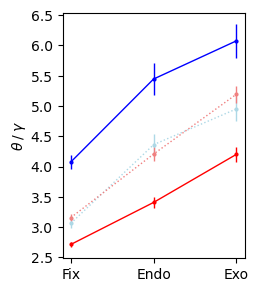

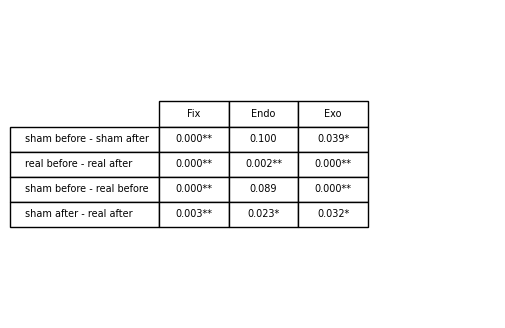

In [8]:
# for band, band_name in enumerate(band_names):
cm = 1/2.54
fig, ax = plt.subplots(figsize=(3.78*cm, 7*cm))
# fig, ax = plt.subplots(figsize=(7*cm, 7*cm))

line_width = 1
marker_size = 2

ax.errorbar(case_names, means[0,:], yerr=ses[0,:], color=colors[0], label='Sham before', marker='o', linestyle=':', linewidth = line_width, markersize=marker_size)
ax.errorbar(case_names, means[1,:], yerr=ses[1,:], color=colors[1], label='Sham after', marker='o', linestyle='-', linewidth = line_width, markersize=marker_size)
ax.errorbar(case_names, means[2,:], yerr=ses[2,:], color=colors[2], label='Real before', marker='o', linestyle=':', linewidth = line_width, markersize=marker_size)
ax.errorbar(case_names, means[3,:], yerr=ses[3,:], color=colors[3], label='Real after', marker='o', linestyle='-', linewidth = line_width, markersize=marker_size)


# ax.axhline(y=0, color='black', linestyle='--')
# x.set_ylim([4.8, 4.9])
# ax.set_xlabel('Trial type')
ax.set_ylabel('$\u03B8\: /\: \gamma$', labelpad=2)
matplotlib.rcParams.update({'font.size': 7})
fig.subplots_adjust(left=0.3, bottom=0.08, right=0.96, top=0.97)
# plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure 5', 'ratio_change.eps')
# save_path = os.path.join('..', '..', '..', '..', '..', '..', 'DThesis', 'chapter3', 'ratio_change.eps')

plt.savefig(save_path, format='eps')
# save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure 5', 'ratio_change.png')
# plt.savefig(save_path, format='png')
plt.show()

session_names = ['sham before', 'sham after', 'real before', 'real after']
case_names = ['Fix', 'Endo', 'Exo']
colors = ['lightblue', 'blue', 'lightcoral', 'red']
row_names = [session_names[0] + " - " + session_names[1],
             session_names[2] + " - " + session_names[3],
             session_names[0] + " - " + session_names[2],
             session_names[1] + " - " + session_names[3]]

plot_colored_table(utest_results, row_names, case_names, colors)